# Analysis of PointNeXt 

#### Guidelines for installing the necessary libraries

In our implementation we use pytorch3d version 0.7.5, which requires Python version from 3.8 up to 3.10. You could use a newer version of Python, but it will require some additional libraries to compile, like cuda-toolkit.

First, make sure you have installed one of the latest drivers; otherwise you can have problems with GPU availability with the PyTorch library. You should pay attention to the CUDA version of your installed driver. Your GPU's CUDA version must be equal to or greater than the CUDA version required by PyTorch. We strongly recommend using a GPU with the given code. You can check your version with this command:

In [1]:
!nvidia-smi

For PyTorch follow the instructions here https://pytorch.org/get-started/locally/. If you are planning to build pythorch3d library for an unsupported version of Python, make sure you download the same version of Cuda Toolkit as your installed PyTorch library supports. The Cuda toolkit can be downloaded here https://developer.nvidia.com/cuda-toolkit-archive/.

Before we can install pytorch3d we need to install some additional libraries. Here we will install all necessary libraries for our code:

In [2]:
%pip install torchinfo scipy seaborn scikit-learn pandas matplotlib k3d ipywidgets watermark ipykernel pyproject.toml wheel

For pytorch3d there are many ways to install it. We went with the one that is supported for Windows. For other ways of installation, you can check here https://github.com/facebookresearch/pytorch3d?tab=readme-ov-file#installation.

If you are installing it under Windows, you will also need Git, can be accessed here https://git-scm.com/download/win, and C++ Build Tools, which can be accessed here https://visualstudio.microsoft.com/visual-cpp-build-tools/. In C++ Build Tools, make sure to check and install "Desktop development with C++". You might need to reboot or close the current terminal in order for Git's path to be updated.

After that we can install pytorch3d from git:

In [3]:
%pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable"

Building pytorch3d with the upper command took around 8 minutes to complete on Ryzen 7.

#### Libraries

In [ ]:
import pandas as pd
# import pyarrow
import numpy as np
import scipy
import copy
import os

import k3d
import ipywidgets as widgets

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch import nn
from torch.cuda.amp import autocast, GradScaler     # can speed up operations of model if your GPU has Tensor Cores (use of Automatic Mixed Precision)
from torch.utils.data import Dataset, DataLoader

from pytorch3d.ops import sample_farthest_points, ball_query, knn_points
from pytorch3d.transforms import RotateAxisAngle

import torchinfo

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,torch,torchvision,pytorch3d

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.22.2

numpy      : 1.26.3
torch      : 2.2.1+cu121
torchvision: 0.17.1+cu121
pytorch3d  : 0.7.5



#### Settings on how the notebook behaves

In [6]:
TRAIN_MODEL = False
ANALYZE_MODEL = False

In [7]:
SPECIES_LANGUAGE = 'english'    # supported languages: 'slovenian', 'english', 'latin'
UI_LANGUAGE = 'english'         # supported languages: 'slovenian', 'english'

#### Global variables

In [8]:
# loading the data
DATASET_CSV_FILENAME = 'meta_dataset.csv'
SPECIES_DATA_CSV_FILENAME = 'meta_tree_species.csv'
NORMALIZED_WITH_CENTERING_POINT_FOLDER_SUFFIX    = ' - NORMALIZED'
DOWNSAMPLED_WITH_NORMALIZATION_AND_CENTERING_POINTS_FOLDER_SUFFIX = ' - DOWNSAMPLED'

In [9]:
# saving data of model
NN_MODEL_FOLDER   = 'models'
NN_CHCKPNT_FOLDER = NN_MODEL_FOLDER + os.sep + 'checkpoints'
NN_CHCKPNT_FOLDER_POINTNEXT = NN_CHCKPNT_FOLDER + os.sep + 'pointnext'
TRAIN_MODEL_NAME = 'pointnext_b'

In [ ]:
RND_SEED = 1708373936
np.random.seed(RND_SEED)    # MT19937
torch.manual_seed(RND_SEED)

In [11]:
BATCH_SIZE = 62     # around 64 was limit for our 8 GB graphics card
# at batch of size 62 we needed almost 12 s to process single epoch

In [12]:
# since we have smaller dataset, we will train first run for 2h
# 2h -> sec = 7_200 sec; divided by time needed to process batch size 68 that is around 12 s -> 600 epochs
EPOCHS = 600

In [13]:
LEARINING_STEPS = 1_000

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE  # shows device that it will be using

device(type='cuda')

## Preparing data for neural network

In [15]:
"""
@origin : PointWOLF.py by {Sanghyeok Lee, Sihyeon Kim}
@Contact: {cat0626, sh_bs15}@korea.ac.kr
@Time: 2021.09.30
"""
# Slighlty modified constructor and __call__ method, there is also addition of comments in important methods/functions

class PointWOLF(object):
    def __init__(self, 
                 anchor_points_count: int = 4,
                 sample_type: str = 'fps',
                 kernel_bandwidth: float = 0.5,
                 R_range_max: float = 10,
                 S_range_max: float = 3,
                 T_range_max: float = 0.25,
                 do_normalization: bool = False,
        ):
        self.num_anchor = anchor_points_count
        self.sigma = kernel_bandwidth
        self.sample_type = sample_type
        self.do_normalization = do_normalization

        self.R_range = (-abs(R_range_max), abs(R_range_max))
        self.S_range = (1., S_range_max)
        self.T_range = (-abs(T_range_max), abs(T_range_max))
        
        
    def __call__(self, pos: np.ndarray):
        """
        input :
            pos([N,3])
            
        output : 
            pos([N,3]) : original pointcloud
            pos_new([N,3]) : Pointcloud augmneted by PointWOLF
        """
        M=self.num_anchor #(Mx3)
        N, _=pos.shape #(N)
        
        if self.sample_type == 'random':
            idx = np.random.choice(N,M)#(M)
        elif self.sample_type == 'fps':
            # idx = self.fps(pos, M) #(M)
            idx = self.fps_optimized(pos, M) #(M)
        
        pos_anchor = pos[idx] #(M,3), anchor point

        ## could also replace self.fps with pytorch3d.ops.sample_farthest_points as shown below
        # tensor_pos = torch.tensor(pos, dtype=torch.float32).unsqueeze(0)
        # print(tensor_pos.shape)
        # pts, idx = sample_farthest_points(tensor_pos, K=M)
        # untensored_pos = pts.squeeze(0).numpy()   # .cpu().numpy()
        # pos_anchor = untensored_pos


        pos_repeat = np.expand_dims(pos,0).repeat(M, axis=0)#(M,N,3)
        pos_normalize = np.zeros_like(pos_repeat, dtype=pos.dtype)  #(M,N,3)
        
        #Move to canonical space
        pos_normalize = pos_repeat - pos_anchor.reshape(M,-1,3)
        
        #Local transformation at anchor point
        pos_transformed = self.local_transformaton(pos_normalize) #(M,N,3)
        
        #Move to origin space
        pos_transformed = pos_transformed + pos_anchor.reshape(M,-1,3) #(M,N,3)
        
        pos_new = self.kernel_regression(pos, pos_anchor, pos_transformed)

        if self.do_normalization:
            pos_new = self.normalize(pos_new)
        
        return pos.astype('float32'), pos_new.astype('float32')
        

    def kernel_regression(self, pos: np.ndarray, pos_anchor: np.ndarray, pos_transformed: np.ndarray):
        """
        Nadaraya-Watson kernel regression, for smootly interpolating the local transformation

        input :
            pos([N,3])
            pos_anchor([M,3])
            pos_transformed([M,N,3])
            
        output : 
            pos_new([N,3]) : Pointcloud after weighted local transformation 
        """
        M, N, _ = pos_transformed.shape
        
        #Distance between anchor points & entire points
        sub = np.expand_dims(pos_anchor,1).repeat(N, axis=1) - np.expand_dims(pos,0).repeat(M, axis=0) #(M,N,3), d
        
        project_axis = self.get_random_axis(1)

        projection = np.expand_dims(project_axis, axis=1)*np.eye(3)#(1,3,3)
        
        #Project distance
        sub = sub @ projection # (M,N,3)
        sub = np.sqrt(((sub) ** 2).sum(2)) #(M,N)  
        
        #Kernel regression
        weight = np.exp(-0.5 * (sub ** 2) / (self.sigma ** 2))  #(M,N) 
        pos_new = (np.expand_dims(weight,2).repeat(3, axis=-1) * pos_transformed).sum(0) #(N,3)
        pos_new = (pos_new / weight.sum(0, keepdims=True).T) # normalize by weight
        return pos_new

    
    def fps(self, pos: np.ndarray, npoint: int):
        """
        Farthest Point Sampling, it maximizes the coverage of anchor points and allows diverse transformations 

        input : 
            pos([N,3])
            npoint(int)
            
        output : 
            centroids([npoints]) : index list for fps
        """
        N, _ = pos.shape
        centroids = np.zeros(npoint, dtype=np.int_) #(M)
        distance = np.ones(N, dtype=np.float64) * 1e10 #(N)
        farthest = np.random.randint(0, N, (1,), dtype=np.int_)

        for i in range(npoint):
            centroids[i] = farthest
            centroid = pos[farthest, :]
            dist = ((pos - centroid)**2).sum(-1)
            mask = dist < distance
            distance[mask] = dist[mask]
            farthest = distance.argmax()
            
        return centroids
    

    def fps_optimized(self, pos: np.ndarray, npoint: int):
        """
        Farthest Point Sampling, it maximizes the coverage of anchor points and allows diverse transformations 

        input : 
            pos([N,3])
            npoint(int)
            
        output : 
            centroids([npoints]) : index list for fps
        """
        N, _ = pos.shape
        centroids = np.zeros(npoint, dtype=np.int_) #(M)
        farthest = np.random.randint(0, N)
        centroids[0] = farthest

        for i in range(1, npoint):
            dist = scipy.spatial.distance_matrix(pos, pos[centroids[:i]])
            farthest = np.argmax(np.min(dist, axis=1)).item()
            centroids[i] = farthest

        return centroids

    

    def local_transformaton(self, pos_normalize: np.ndarray):
        """
        Local transformation at anchor points, including rotation, scaling, and translation

        input :
            pos([N,3]) 
            pos_normalize([M,N,3])
            
        output :
            pos_normalize([M,N,3]) : Pointclouds after local transformation centered at M anchor points.
        """
        M,N,_ = pos_normalize.shape
        transformation_dropout = np.random.binomial(1, 0.5, (M,3)) #(M,3)
        transformation_axis =self.get_random_axis(M) #(M,3)

        degree = np.pi * np.random.uniform(*self.R_range, size=(M,3)) / 180.0 * transformation_dropout[:,0:1] #(M,3), sampling from (-R_range, R_range) 
        
        scale = np.random.uniform(*self.S_range, size=(M,3)) * transformation_dropout[:,1:2] #(M,3), sampling from (1, S_range)
        scale = scale*transformation_axis
        scale = scale + 1*(scale==0) #Scaling factor must be larger than 1
        
        trl = np.random.uniform(*self.T_range, size=(M,3)) * transformation_dropout[:,2:3] #(M,3), sampling from (1, T_range)
        trl = trl*transformation_axis
        
        #Scaling Matrix
        S = np.expand_dims(scale, axis=1)*np.eye(3) # scailing factor to diagonal matrix (M,3) -> (M,3,3)
        #Rotation Matrix
        sin = np.sin(degree)
        cos = np.cos(degree)
        sx, sy, sz = sin[:,0], sin[:,1], sin[:,2]
        cx, cy, cz = cos[:,0], cos[:,1], cos[:,2]
        R = np.stack([cz*cy, cz*sy*sx - sz*cx, cz*sy*cx + sz*sx,
             sz*cy, sz*sy*sx + cz*cy, sz*sy*cx - cz*sx,
             -sy, cy*sx, cy*cx], axis=1).reshape(M,3,3)
        
        pos_normalize = pos_normalize@R@S + trl.reshape(M,1,3)
        return pos_normalize
    

    def get_random_axis(self, n_axis: int):
        """
        input :
            n_axis(int)
            
        output :
            axis([n_axis,3]) : projection axis   
        """
        axis = np.random.randint(1,8, (n_axis)) # 1(001):z, 2(010):y, 3(011):yz, 4(100):x, 5(101):xz, 6(110):xy, 7(111):xyz    
        m = 3 
        axis = (((axis[:,None] & (1 << np.arange(m)))) > 0).astype(int)
        return axis
    
    
    def normalize(self, pos: np.ndarray):
        """
        input :
            pos([N,3])
        
        output :
            pos([N,3]) : normalized Pointcloud
        """
        pos = pos - pos.mean(axis=-2, keepdims=True)
        scale = (1 / np.sqrt((pos ** 2).sum(1)).max()) * 0.999999
        pos = scale * pos
        return pos

In [16]:
class PointCloudDataset(Dataset):
    def __init__(self, 
                 dataset_type: str = 'train', 
                 rotation_sides_limit: list = [0, 379], 
                 scaling_factor_limits: list = [0.66, 1.5], # values used for PointNeXt
                 max_percentage_color_change: float = 0.3,
                 pointwolf: PointWOLF = None,
                 pntWLF_max_anchor_points: int = 4,
                 do_centering: bool = False,
                 do_normalization: bool = False,
        ):        
        self.rotation_sides_deg = rotation_sides_limit
        self.scaling_factor_limits = scaling_factor_limits
        self.max_percentage_color_change = max_percentage_color_change
        self.pointwolf = pointwolf
        self.pntWLF_max_anchor_points = pntWLF_max_anchor_points
        self.do_centering = do_centering
        self.do_normalization = do_normalization
        
        # read dataset and only save dataset_type data
        dataframe = pd.read_csv(DATASET_CSV_FILENAME, delimiter='\t', encoding='utf-8')
        chosen_df = dataframe[dataframe['dataset_type'] == dataset_type]

        self.normal_point_clouds = chosen_df.reset_index(drop=True)
        # self.normal_point_clouds.info()
        
        # save label data for later use
        self.label_names = chosen_df['species_name'].unique()
        self.label_dic = {value: index for index, value in enumerate(self.label_names)}


    def set_pointwolf(self, pointwolf: PointWOLF):
        self.pointwolf = pointwolf


    def class_count(self):
        return len(self.label_names)
    

    def get_information_about_dataset(self):
        label_names_counts = {}

        for label in self.label_names:
            label_names_counts[label] = len(self.normal_point_clouds[self.normal_point_clouds['species_name'] == label])

        return label_names_counts


    def __len__(self):
        return len(self.normal_point_clouds)


    def __getitem__(self, idx):
        df_row = self.normal_point_clouds.loc[idx]

        # load point cloud and move to CPU/GPU
        points = np.loadtxt(df_row['path'] + os.sep + df_row['filename'], dtype=np.float32, usecols=(0,1,2))    # it wont read colors nor normals

        original_points = copy.deepcopy(points)
        points = torch.from_numpy(points)   # .to(DEVICE)


        # augmentation
        side_angle_rotation = np.random.randint(self.rotation_sides_deg[0], self.rotation_sides_deg[1], 1) [0]
        R_side = RotateAxisAngle(side_angle_rotation, axis="Z")

        current_anchor_points_count = np.random.randint(0, self.pntWLF_max_anchor_points, 1)[0]

        # side rotation
        points = R_side.transform_points(points)
        points = points.cpu().numpy()

    	# pointWOLF
        if self.pointwolf and current_anchor_points_count > 0:
            self.pointwolf.num_anchor = current_anchor_points_count
            pts, pts_aug = self.pointwolf(points)
            points = pts_aug


        # scaling (wont be used, since we are using normalization; look at the end for more info)
        if not self.do_normalization:
            scale_factor = np.random.uniform(self.scaling_factor_limits[0], self.scaling_factor_limits[1], 1)[0]
            
            points = points * scale_factor

        # Centering
        if self.do_centering:
            points -= np.mean(points, axis=0, keepdims=True)

        # Normlization (we will be using it since the data used comes from different sources and it has different scales)
        if self.do_normalization:
            points /= np.max(np.linalg.norm(points, axis=1))

        

        # preparing labels
        current_label_index = self.label_dic[df_row['species_name']]
        labels = torch.nn.functional.one_hot(
            torch.tensor([current_label_index]),
            num_classes=len(self.label_names)
            ).permute(1, 0).squeeze(-1).float()


        # addition of grayscale color to the points
        rgb = np.zeros((points.shape[0], 3), dtype=np.float32) 
        aug_rgb = copy.deepcopy(rgb)

        # color augmentation
        randomly_selected_points_count_to_have_different_color = int(points.shape[0] * np.random.uniform(0, self.max_percentage_color_change, 1)[0]) 

        random_grayscale_color = np.random.randint(1, 255, 3) / 255
        randomly_select_point_indexes = np.random.choice(
            np.arange(0, points.shape[0]), 
            size=randomly_selected_points_count_to_have_different_color, 
            replace=False
        )

        aug_rgb[randomly_select_point_indexes] = random_grayscale_color


        return torch.from_numpy(np.concatenate((original_points, rgb), axis=-1)), torch.from_numpy(np.concatenate((points, aug_rgb), axis=-1)), labels

In [17]:
temp_dataset = PointCloudDataset()
temp_dataset.set_pointwolf(PointWOLF())

temp_data_loader = DataLoader(temp_dataset, batch_size=3, shuffle=True)

In [18]:
NUM_CLASSES = temp_dataset.class_count()

In [19]:
orig, augm, labels = next(iter(temp_data_loader))
DATASET_CHANNEL_DEPTH = augm.shape[-1]

In [20]:
# it can take some time to render the plots
def plot_interactive_point_clouds_from_dataloader(dataloader: DataLoader):
    orig, augm, labels = next(iter(dataloader))
    batch_size = orig.shape[0]

    orig_xyz = orig[:,:, :3]
    augm_xyz = augm[:,:, :3]

    orig_rgb = orig[:,:, 3:4]
    augm_rgb = augm[:,:, 3:4]

    # print(orig_rgb[0].shape, augm_rgb[0].shape)

    point_clouds = []
    pc_colors = []

    for i in range(batch_size):
        point_clouds.append(orig_xyz[i].numpy())
        point_clouds.append(augm_xyz[i].numpy())
        
        pc_colors.append(orig_rgb[i].numpy())
        pc_colors.append(augm_rgb[i].numpy())


    plots = []

    # for cloud_point in point_clouds:
    for i in range(len(point_clouds)):
        current_plot = k3d.plot()
        current_points = k3d.points(
            np.float32(point_clouds[i]), 
            point_size=0.001, 
            colors=pc_colors[i] * 255
        )
        current_plot += current_points
        plots.append(current_plot)
        

    subplots = widgets.GridBox(plots, layout=widgets.Layout(grid_template_columns="repeat("+ str(2) +", 1fr)"))
    display(subplots)

should look something like this

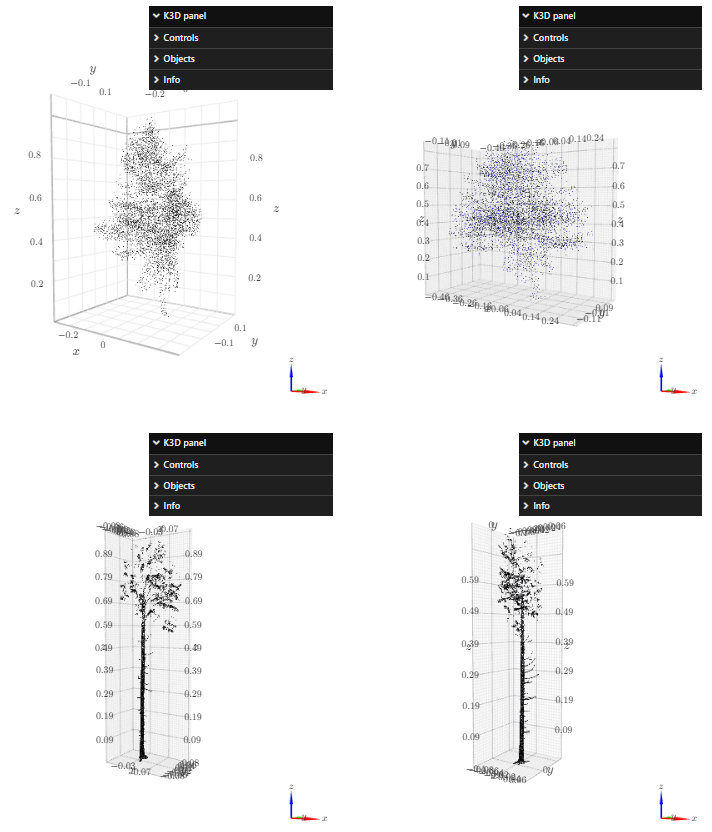

In [ ]:
plot_interactive_point_clouds_from_dataloader(temp_data_loader)

In [22]:
def show_dataset_species_count(dataset, species_language: str = SPECIES_LANGUAGE, show_bar_chart: bool = True):
    dic_information = dataset.get_information_about_dataset()
    df = pd.read_csv(SPECIES_DATA_CSV_FILENAME, delimiter='\t', encoding='utf-8')

    substring = '_name'
    matching_columns = [col for col in df.columns if substring in col]
    language_columns = [col.replace(substring, '') for col in matching_columns]
    
    if species_language not in language_columns:
        raise ValueError('Language not supported')

    if not show_bar_chart:
        print("Species count:")

        for key, value in dic_information.items():
            if  'latin' == species_language:
                species_name = key
            else:
                species_name = df.loc[df['latin_name'] == key, f'{species_language}_name'].values[0]
                
            print(f" - {species_name}: {value}")

    else:
        if  'latin' == species_language:
            species_names = list(dic_information.keys())
        else:
            species_names = [df.loc[df['latin_name'] == key, f'{species_language}_name'].values[0] for key in dic_information.keys()]

        species_counts = list(dic_information.values())
        colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(species_names))]

        plt.figure(figsize=(12, 8))
        plt.bar(species_names, species_counts, color=colors)
        plt.xticks(rotation=90)
        plt.show()

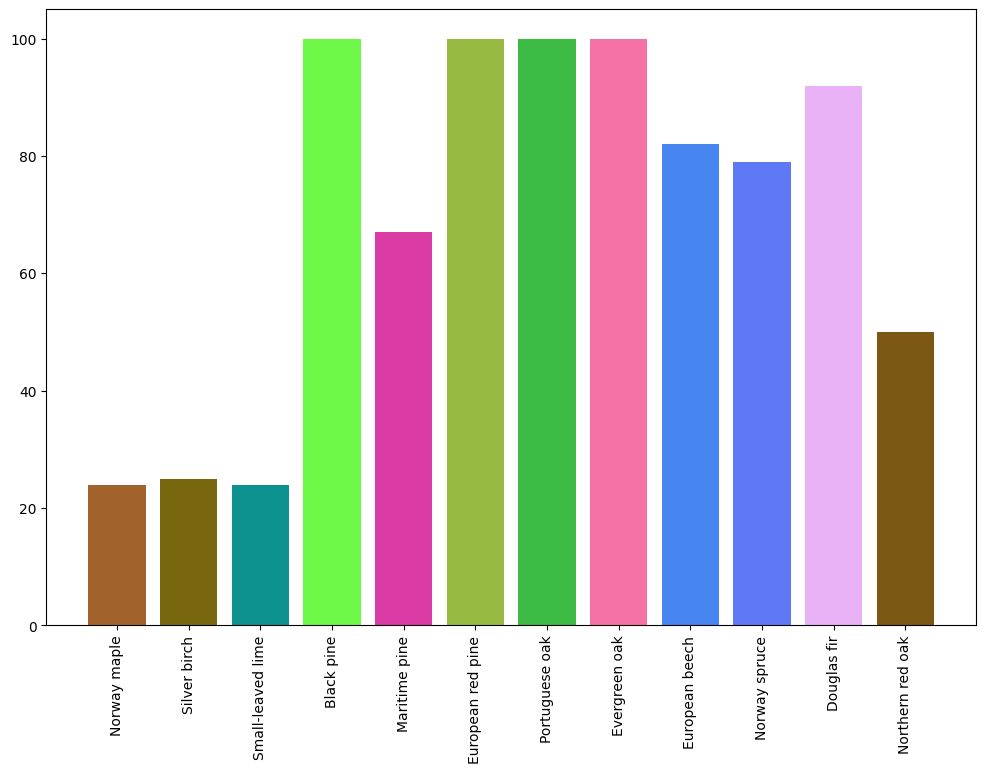

In [23]:
show_dataset_species_count(temp_dataset)

## PointNeXt

In [24]:
class MLP(nn.Module):
    '''
    Multi Layer Perceptron for PointNeXt
    based on 1d or 2d convolutional layer with batch normalization and relu activation
    '''

    def __init__(self,
            in_channel: int, 
            out_channel: int,
            expecting_residual_connection: bool = False,
            replace_conv1d_with_linear: bool = False,
            dim: int = 2,
        ):
        """
        :param in_channel:                      int, number of input channels
        :param out_channel:                     int, number of output channels
        :param expecting_residual_connection:   bool, if expecting residual connection
        :param replace_conv1d_with_linear:      bool, if expecting to replace 1d convolutional layer with linear layer; only for classification head
        :param dim:                             int, type of convolution layer with kernel=1 to use (1d or 2d)
        """
        super().__init__()

        if 1 == dim:
            Conv = nn.Conv1d
            kernel = 1
            normalization = nn.BatchNorm1d
        else:
            Conv = nn.Conv2d
            kernel = (1, 1)   # colud also write as Conv.kernel_size = 1
            normalization = nn.BatchNorm2d


        layers = []

        # fully connected layer
        if replace_conv1d_with_linear:
            layers.append(nn.Linear(in_channel, out_channel, bias=False))
        else:
            layers.append(Conv(in_channel, out_channel, kernel_size=kernel, bias=False))  

        layers.append(normalization(out_channel))

        # if using residual connection, we need to skip here activation function
        if not expecting_residual_connection:
            layers.append(nn.ReLU(inplace=True))

        self.mlp = nn.Sequential(*layers)


    def forward(self, x):
        return self.mlp(x)

In [25]:
def subsampling(points_xyz: torch.Tensor, samples_size: int):
    """
    sample farthest points based (sub)sampling

    :param points:          (B, N, D=3) tensor -> (batch_size, number_of_points, dimension_of_points), coordinates of the points
    :param samples_size:    int, number of points in each sample
    :return:
        sampled_points      (B, samples_size, D=3) tensor, sampled points                
        idx                 (B, samples_size) tensor, indices of sampled points
    """

    sampled_points, idx = sample_farthest_points(points_xyz, K=samples_size, random_start_point=False)
    return sampled_points, idx


def grouping(points: torch.Tensor, centroids: torch.Tensor, radius: float, samples_size: int):

    """
    ball query based grouping
    
    :param points:          (B, N, D=3) tensor -> (batch_size, number_of_points, dimension_of_points)
    :param centroids:       (B, M, D=3) tensor -> (batch_size, number_of_centroids, dimension_of_points)
    :param radius:          float, radius of the current centroid
    :param samples_size:    int, number of points in each region
    :return:                
        output.dists        (B, N, K) tensor, distances to the centroids
        output.idx          (B, N, K) tensor, indices of original points for each centroid
        output.knn          (B, N, K, D=3) tensor, coordinates of the points in each centroid
    """

    output = ball_query(points, centroids, radius=radius, K=samples_size, return_nn=True)   
        # can return 2 or 3 tensors, 2 if return_nn=False, 3 if return_nn=True; dists, idx, nn
        # we want all three, but the last one we want the most    
    
    return output.dists, output.idx, output.knn   # dists, idx



def gather_point_features(point_data: torch.Tensor, idx: torch.Tensor):
    """
    :param point_data:      (B, N, D) tensor, points with only xyz or all features
    :param idx:             (B, M, C) tensor, indices of points features
    :return:                (B, M, C, D) tensor, features of the points

    """

    # creates a tensor [B, 1, 1] of values [0, ..., B-1]
    batch_indices = torch.arange(
        point_data.shape[0],        # B
        dtype=idx.dtype, 
        device=point_data.device
    ).view(
        -1, 
        *[1]*(idx.dim()-1)
    )

    return point_data[batch_indices, idx, :]

### Set Abstraction

In [26]:
class SetAbstraction(nn.Module):
    '''
    Originally from PointNet++, modified with residual connection
    '''

    def __init__(self, 
            in_channel: int,
            out_channel: int,
            downsample_factor: int, 
            region_size: int, 
            radius: float, 
            point_dimensions: int = 3, 
            use_residual_connection: bool = False,
        ):
        '''
        :param in_channel:              int, number of input channels
        :param out_channel:             int, number of output channels
        :param downsample_factor:       int, factor by which the number of points is reduced
        :param region_size:             int, number of points in each region, also denoted as K
        :param radius:                  float, radius of the current centroid
        :param point_dimensions:        int, dimension of the points, also denoted as D
        :param use_residual_connection: bool, whether to use residual connection
        '''

        super().__init__()
        self.downsample_factor = downsample_factor
        self.region_size = region_size
        self.radius = radius
        self.use_residual_connection = use_residual_connection  # also known as skip, only used for PointNeXt-S where are 2 SA blocks used

        if not self.use_residual_connection:
            self.mlp = MLP(
                in_channel + point_dimensions, 
                out_channel
            )

        else:
            self.mlp = MLP(
                in_channel + point_dimensions, 
                in_channel
            )

            # only used for PointNeXt-S where shortcut and 2 MLP blocks are used but no InvResMLP blocks
            self.second_mlp = MLP(
                in_channel, 
                out_channel, 
                expecting_residual_connection=True,
            )   
        

        self.activation_after_residual = nn.ReLU(inplace=True) 

        if self.use_residual_connection:
            self.residual_connection = nn.Conv1d(in_channel, out_channel, 1, bias=True) if in_channel != out_channel else nn.Identity()



    def forward(self, points_xyz, point_features):
        '''
        :param points_xyz:      (B, D=3, N) tensor
        :param point_features:  (B, C,   N) tensor
        '''
        
        sample_point_count = point_features.shape[-1] // self.downsample_factor

        points_xyz, point_features = points_xyz.permute(0, 2, 1), point_features.permute(0, 2, 1)# (B, N, D), (B, N, C)


        # sample_idx will be used only for PointNeXt-S
        sampled_points, sample_idx = subsampling(points_xyz, sample_point_count)  # (B, N', D)   N' = sampled_point_count

        # in some implementation this part is known as "LocalAggregation"
        _, regioned_idx, regioned_points = grouping(sampled_points, points_xyz, self.radius, self.region_size) # (B, N', K, D)  K = region_size


        regioned_points -= sampled_points.unsqueeze(-2) # it will add single dimension (1) to position where the K dimension is in regioned_points
        regioned_points /= self.radius  # (B, N', K, D)


        regioned_features = gather_point_features(point_features, regioned_idx) # (B, N', K, C)


        regioned_features = torch.cat((regioned_features, regioned_points), dim=-1) # (B, N', K, C+D)

        
        regioned_features = regioned_features.permute(0, 3, 2, 1) # (B, C+D, K, N')

        new_features = self.mlp(regioned_features) # (B, E, K, N')


        # only for PointNeXt-S, since it uses 2 SA blocks
        if self.use_residual_connection:
            new_features = self.second_mlp(new_features)    # (B, E, K, N')


        # reduction
        new_features = new_features.max(dim=-2)[0] # (B, E, N'), behaves like a (max) pooling layer, it removes K dimension


        # only for PointNeXt-S, since it uses residual connection
        if self.use_residual_connection:
            sampled_features = gather_point_features(point_features, sample_idx)  # (B, N', C)
            shortcut_features = sampled_features.permute(0, 2, 1)  # (B, N', C) -> (B, C, N')

            res_conn = self.residual_connection(shortcut_features)

            new_features += res_conn
            new_features = self.activation_after_residual(new_features)


        sampled_points = sampled_points.permute(0, 2, 1) # (B, D=3, N')
        
        return sampled_points, new_features # (B, D=3, N'), (B, E, N')

### Inverted Residual MLP

In [27]:
class InvResMLP(nn.Module):
    '''
    Inverted Residual MLP, new
    '''

    def __init__(self, 
            in_channel: int,
            region_size: int, 
            radius: float,
            point_dimensions: int = 3,
            expansion_factor: int = 4
        ):
        '''
        :param in_channel:          int, number of input channels
        :param region_size:         int, number of points in each region, also denoted as K
        :param point_dimensions:    int, dimension of the points, also denoted as D
        :param expansion_factor:    int, expension factor for the number of channels
        :param radius:              float, radius of the current centroid
        '''

        super().__init__()
        self.in_channel = in_channel
        self.region_size = region_size
        self.point_dimensions = point_dimensions
        self.radius = radius
        
        
        self.first_mlp = MLP(
            in_channel + point_dimensions, 
            in_channel, 
            dim=2
        )
        self.second_mlp = MLP(
            in_channel, 
            in_channel * expansion_factor, 
            dim=1
        )
        self.third_mlp = MLP(
            in_channel * expansion_factor, 
            in_channel, 
            expecting_residual_connection=True, 
            dim=1
        )
        self.relu = nn.ReLU(inplace=True)

    
    def forward(self, points_xyz, point_features):
        '''
        :param points_xyz:      (B, D=3, N) tensor
        :param point_features:  (B, C,   N) tensor
        '''
        
        shortcut_features = point_features   # (B, C, N), residual connection

        # in some implementation this part is known as "LocalAggregation"
        points_xyz, point_features = points_xyz.permute(0, 2, 1), point_features.permute(0, 2, 1)


        _, regioned_idx, regioned_points = grouping(points_xyz, points_xyz, self.radius, self.region_size) # (B, N', K, D)  K = region_size

        regioned_points -= points_xyz.unsqueeze(-2) # it will add single dimension (1) to position where the K dimension is in regioned_points
        regioned_points /= self.radius  # (B, N', K, D) the same as before

        regioned_features = gather_point_features(point_features, regioned_idx) # (B, N', K, C)

        regioned_features = torch.cat((regioned_features, regioned_points), dim=-1) # (B, N', K, C+D)
        
        regioned_features = regioned_features.permute(0, 3, 2, 1) # (B, C+D, K, N')

        new_features = self.first_mlp(regioned_features) # (B, E, K, N')
        
        reduced_new_features = new_features.max(dim=-2)[0] # (B, E, N'), behaves like a (max) pooling layer, it removes K dimension
        # end of "LocalAggregation"


        x = self.second_mlp(reduced_new_features)
        x = self.third_mlp(x)

        if shortcut_features.shape[1] == x.shape[1]:
            x = x + shortcut_features

        x = self.relu(x)
        points_xyz = points_xyz.permute(0, 2, 1) # (B, D=3, N')

        return points_xyz, x    # (B, D=3, N'), (B, C, N')

### Stage for encoders

In [28]:
class EncoderStage(nn.Module):
    '''
    Includes SA block and InvResMLP block, represents building block of encoder
    '''

    def __init__(self, 
            in_channel: int,                # prejsn stage out_channel
            out_channel: int,               # [N/number, value]; value should be used here
            invresmlp_block_count: int,     # B = (a, b, c, d); one of this values will be used here
            downsample_factor: int,         # number from N / number (4, 16, 64, 256, 512)
            region_size_list: list[int],
            radius_list: list[float],
            point_dimensions: int = 3,
            expansion_factor: int = 4,
        ):
        '''
        :param in_channel:          int, number of input channels
        :param out_channel:         int, number of output channels ([N/number, value] -> this is the value)
        :param downsample_factor:   int, number from [N/number, value] (this is the N/numbrer which can be 4, 16, 64, 256, 512 or other)
        :param sampled_point_count: int, number of points in each sample, also denoted as N
        :param region_size_list:    list of ints, number of points in each region, also denoted as K
        :param radius_list:         list of floats, radius of the current centroid; first value for SA block, other values for InvResMLP blocks
        :param point_dimensions:    int, dimension of the points, also denoted as D in PointNet++ paper
        :param expansion_factor:    int, expension factor for the number of channels
        '''

        super().__init__()

        # whether residual connection is used in SA block (only used for PointNeXt-S where SA blocks has 2 MLP blocks instead of 1 and it uses residual connection)
        use_residual_connection = False if 0 < invresmlp_block_count else True

        self.sa_block = SetAbstraction(
            in_channel,
            out_channel, 
            downsample_factor,
            region_size_list[0], 
            radius_list[0], 
            point_dimensions, 
            use_residual_connection,
        )

        self.invresmlp_blocks = []
        
        for i in range(invresmlp_block_count):
            self.invresmlp_blocks.append(
                InvResMLP(
                    out_channel,            # in_channel*2, 
                    region_size_list[i+1], 
                    radius_list[i+1], 
                    point_dimensions, 
                    expansion_factor,
                )
            )

        self.invresmlp_blocks = nn.ModuleList(self.invresmlp_blocks)


    def forward(self, points_xyz, point_features):
        '''
        :param points_xyz:      (B, D=3, N) tensor
        :param point_features:  (B, C, N) tensor
        '''
        
        sampled_points, new_features = self.sa_block(points_xyz, point_features) 
        
        output_xyz, output_features = sampled_points, new_features

        for index in range(len(self.invresmlp_blocks)):
            output_xyz, output_features = self.invresmlp_blocks[index](output_xyz, output_features)

        return output_xyz, output_features   

### Feature Propagation

In [29]:
class FeaturePropagation(nn.Module):
    '''
    Originaly from PointNet++
    Up-sampling layer, this is the only component of decoder therefor building block of decoder
    '''

    def __init__(self, 
            lower_channel: int,
            upper_channel: int,
        ):
        '''
        :param mlp:                 list of ints, number of channels for each layer, example [current_channels, next_channels, next_channels]
        :param lower_channel:       int, number of channels of the lower InvResMLP block
        :param upper_channel:       int, number of channels of the upper InvResMLP block 
        :param point_dimensions:    int, dimension of the points, also denoted as D
        '''

        super().__init__()

        self.mlps = [
            MLP(lower_channel + upper_channel, upper_channel, dim=1),
            MLP(upper_channel,                 upper_channel, dim=1),
        ]

        self.mlps = nn.ModuleList(self.mlps)


    def forward(self, lower_xyz, upper_xyz, lower_features, upper_features):
        '''
        :param lower_points:        (B, D=3, N) tensor, coordinates of the current points
        :param upper_points:        (B, D=3, M) tensor, coordinates of the upper points
        :param lower_features:      (B, C1, N) tensor, features of the current points
        :param upper_features:      (B, C2, M) tensor, features of the upper points
        :return: 
        '''

        lower_xyz, upper_xyz = lower_xyz.permute(0, 2, 1), upper_xyz.permute(0, 2, 1)     # upper_features.permute(0, 2, 1)
        lower_features = lower_features.permute(0, 2, 1)


        # Compute K-Nearest Neighbors
        knn_result = knn_points(upper_xyz, lower_xyz, K=3)

        dist_recip = 1.0 / knn_result.dists.clamp(min=1e-8)
        norm = torch.sum(dist_recip, dim=2, keepdim=True)
        weight = dist_recip / norm


        interpolated_features = torch.sum(
            gather_point_features(lower_features, knn_result.idx) * weight.unsqueeze(-1), 
            dim=2,
        )

        # (B, N, D2) -> (B, D2, N)
        interpolated_features = interpolated_features.permute(0, 2, 1)

        # concatenate features
        combined_points = torch.cat([upper_features, interpolated_features], dim=1)
        
        # apply MLPs
        new_features = combined_points

        for index in range(len(self.mlps)):
            new_features = self.mlps[index](new_features)   # combined_points become new_features

        return new_features

### Finalizing structure

In [30]:
# support only for classification and semantic segmentation (no part segmentation)
class PointNeXt(nn.Module):

    def __init__(self,
            classes_count: int,
            point_cloud_channel_depth: int,
            invresmlp_block_count: list[int],
            sample_or_region_size: int = 32, # 32 (k)
            architecture_type: int = 0,
            stem_out_channel: int = 32,                                   # only PointNeXt-XL has different value, that is 64
            radius: float = None,
            radius_scaling_factor: float = None,                            # only PointNeXt-XL has different value, that is 1.0
            downsample_factor: list[int] = [4, 4, 4, 4],
            encoder_out_channels: list[int] = [64, 128, 256, 512],  # for all configurations except PointNeXt-XL, which has [128, 256, 512, 1024]
            head_mlp: list[int] = [512, 256],
            dropout_rate: float = 0.5,
            category_count: int = 0,    # only important for (part) segmentation, not supported !!!
        ):
        '''
        :param classes_count:       int, number of output classes
        :param invresmlp_block_count: list of ints, number of InvResMLP blocks in each stage; in paper this is denoted as B
        :param sample_or_region_size: int, number of points in each sample/region for ball query algorithm; denoted as K in PointNet++ paper, other implementations name it nsample
        :param stem_out_channel:    int, number of input channels; in PointNet++ paper this is denoted as C, as nown as width
        :param region_size_list:    list of ints, number of points in each region, also denoted as Ks
        :param architecture_type:   int, sets head 0 -> classification, 1 -> segmentation
        :param downsampling_factor: list of ints, number of points in each sample; since there is symmetric decoder this will be used in reverse order for decoder
        :param encoder_out_channels:list of ints, number of out channels for MLP/s inside each layer; since there is symmetric decoder this will be used in reverse order for decoder
        '''

        super().__init__()

        if 32 != stem_out_channel and 64 != stem_out_channel:
            raise ValueError('stem_out_channel must be 32 or 64')

        if not (0 == len(invresmlp_block_count) or 4 == len(invresmlp_block_count)):
            raise ValueError('invresmlp_block_count must be empty or have 4 values')
        
        if 0 > sample_or_region_size:
            raise ValueError('sample_or_region_size must be greater than 0')

        if architecture_type not in {0, 1}:
            raise ValueError('architecture_type must be 0 or 1')
        
        if not 4 == len(downsample_factor):
            raise ValueError('downsampling_factor must have 4 values')
        
        if not 4 == len(encoder_out_channels):
            raise ValueError('encoder_out_channels must have 4 values')
            

        self.architecture_type = architecture_type
        self.invresmlp_block_count = invresmlp_block_count
        self.stem_out_channel = stem_out_channel
        

        # stem (first MLP layer in PointNeXt)
        self.stem = nn.Conv1d(
            in_channels=point_cloud_channel_depth,
            out_channels=stem_out_channel,
            kernel_size=1,
            bias=True
        )
        
        
        # encoder
        # for classification
        if 0 == architecture_type:
            starting_radius = radius

            if starting_radius is None:
                starting_radius = 0.15  # setting for ScanObjectNN, lowering from 0.2 to 0.15 slightly improves performance; but this value/s differ from dataset to dataset
                
                
            radius_scaling_factor = radius_scaling_factor

            if radius_scaling_factor is None:
                radius_scaling_factor = 1.5
                

        # for segmentation
        else:  
            starting_radius = radius

            if starting_radius is None:
                starting_radius = 0.1   # setting for S3DIS, better value is 0.1; but again this value/s differ from dataset to dataset
                

            radius_scaling_factor = radius_scaling_factor

            if radius_scaling_factor is None:
                radius_scaling_factor = 2
                
                

        # after each downsample, radius is multiplied by 2
        radius_sa_list = [starting_radius * (2 ** i ) for i in range(len(encoder_out_channels))]

        self.four_encoder_stages = []
        current_in_channel = stem_out_channel


        # only for PointNeXt-S, since it does not use InvResMLP blocks, and it this way we avoid error below
        if 0 == len(invresmlp_block_count):
            invresmlp_block_count = [0] * len(encoder_out_channels)


        for index in range(len(encoder_out_channels)):
            radius_list = [radius_sa_list[index]] + [radius_sa_list[index] * radius_scaling_factor for i in range(invresmlp_block_count[index])]
            
            region_sizes = [sample_or_region_size] + [sample_or_region_size for i in range(invresmlp_block_count[index])]

            self.four_encoder_stages.append(
                EncoderStage(
                    in_channel=current_in_channel,
                    out_channel=encoder_out_channels[index], 
                    invresmlp_block_count=invresmlp_block_count[index], 
                    downsample_factor=downsample_factor[index], 
                    region_size_list=region_sizes, 
                    radius_list=radius_list,
                )
            )

            current_in_channel = encoder_out_channels[index]

        self.four_encoder_stages = nn.Sequential(*self.four_encoder_stages)

        
        
        # decoder
        self.four_decoder_stages = []

        # classification does not use decoder
        if 0 != architecture_type:
            decoder_list = list(reversed(encoder_out_channels)) + [stem_out_channel]

            for index in range(len(decoder_list) - 1):
                
                self.four_decoder_stages.append(
                    FeaturePropagation(
                        lower_channel=decoder_list[index],
                        upper_channel=decoder_list[index + 1],
                    )
                )

            self.four_decoder_stages = nn.Sequential(*self.four_decoder_stages)



        # head
        # slightly different end for classification and segmentation (conv1d can be problematic for classification)
        self.head = []
        
        if 0 == architecture_type:
            head_mlp = [encoder_out_channels[-1]] + head_mlp
        else:   
            head_mlp = [stem_out_channel, stem_out_channel]
        

        for index in range(len(head_mlp) - 1):
            self.head.append(
                MLP(
                    head_mlp[index], 
                    head_mlp[index + 1], 
                    dim=1,
                    replace_conv1d_with_linear=True if 0 == architecture_type else False
                )
            )
            self.head.append(nn.Dropout(p=dropout_rate))
        
        
        if 0 == architecture_type:
            self.head.append(
                nn.Linear(
                    head_mlp[-1], 
                    classes_count,
                    bias=True
                )
            )
        else:
            self.head.append(
                nn.Conv1d(
                    head_mlp[-1], 
                    classes_count,
                    kernel_size=1,
                    bias=True
                )
            )

        
        self.head = nn.Sequential(*self.head)


        # # part segmentation (not tested)
        # # implementation from https://github.com/kentechx/pointnext
        # if 0 < category_count:
        #     self.category_embedding = nn.Embedding(category_count, head_mlp[-1])
        # # and here is implemententation of part segmentation for offical implementation https://github.com/guochengqian/openpoints/blob/baeca5e319aa2e756d179e494469eb7f5ffd29f0/models/backbone/pointnext.py#L641 (there could be one two implementations)



    def forward(self, point_clouds, categories=None):
        '''
        :param point_clouds:        (B, C, N) tensor, features of points (xyz + optional features as rgb and normals)
        :return:                    (B, class_count) / (B, class_count, N) tensor, class/seg scores
        '''

        # generate one variable for all features and one for only xyz
        points_only_xyz = point_clouds[:, :3, :]
        points_all_features = point_clouds
        

        # stem
        points_features = self.stem(points_all_features)


        # encoders
        first_xyz, first_features = self.four_encoder_stages[0](points_only_xyz, points_features)

        second_xyz, second_features = self.four_encoder_stages[1](first_xyz, first_features)
        
        third_xyz, third_features = self.four_encoder_stages[2](second_xyz, second_features)

        fourth_xyz, fourth_features = self.four_encoder_stages[3](third_xyz, third_features)


        # max global pooling (only classification)
        if 0 == self.architecture_type:
            last_processed_features = torch.max(fourth_features, dim=-1, keepdim=False)[0]  # (B, C, N) -> (B, C), has to be set to keepdim=False otherwise it can not be passed to the head


        # decoder (only segmentation)
        else:
            # decoders
            decoder_fourth_features = self.four_decoder_stages[0](fourth_xyz, third_xyz, fourth_features, third_features)

            decoder_third_features = self.four_decoder_stages[1](third_xyz, second_xyz, decoder_fourth_features, second_features) 

            decoder_second_features = self.four_decoder_stages[2](second_xyz, first_xyz, decoder_third_features, first_features)

            decoder_first_features = self.four_decoder_stages[3](first_xyz, points_only_xyz, decoder_second_features, points_features)

            last_processed_features = decoder_first_features    # (B, class_count, N)

            # # not tested
            # # from https://github.com/kentechx/pointnext
            # if 0 < category_count and categories is not None:
            #     category_features = self.category_embedding(categories)
            #     last_processed_features += category_features.unsqueeze(-1)


        # head
        scores = self.head(last_processed_features)


        # # remove last dimension (only classification)
        # if 0 == self.architecture_type:
        #     scores = scores.squeeze(-1)


        return scores
    

    def get_model_specific_configuration(self):
        output = f'C: {self.stem_out_channel}\n'
        output += f'B: {self.invresmlp_block_count}'
        return output

### Settings for the configurations

In [31]:
class PointNeXtConfig():
    def __init__(self,
            C: int,
            B: list[int],
        ):
        self.C = C
        self.B = B

In [32]:
PNTNXT_S_CONFIG = PointNeXtConfig(
    C = 32,
    B = [],
)

PNTNXT_B_CONFIG = PointNeXtConfig(
    C = 32,
    B = [1, 2, 1, 1],
)

PNTNXT_L_CONFIG = PointNeXtConfig(
    C = 32,
    B = [2, 4, 2, 2],
)

PNTNXT_XL_CONFIG = PointNeXtConfig(
    C = 64,
    B = [3, 6, 3, 3],
)

In [33]:
pointnext = PointNeXt(
    point_cloud_channel_depth = DATASET_CHANNEL_DEPTH,
    classes_count = NUM_CLASSES,
    stem_out_channel = PNTNXT_B_CONFIG.C,
    invresmlp_block_count = PNTNXT_B_CONFIG.B,
    # architecture_type = 1,    # this will make it a (semantic) segmentation model
).to(DEVICE)

#### Model's structure outlined

In [34]:
torchinfo.summary(pointnext, (1, DATASET_CHANNEL_DEPTH, 6144), depth=7)
# torchinfo.summary(pointnext, input_size=((1, DATASET_CHANNEL_DEPTH, 6144), categories_shape), depth=7)

Layer (type:depth-idx)                                  Output Shape              Param #
PointNeXt                                               [1, 12]                   --
├─Conv1d: 1-1                                           [1, 32, 6144]             224
├─Sequential: 1-2                                       --                        --
│    └─EncoderStage: 2-1                                [1, 3, 1536]              --
│    │    └─SetAbstraction: 3-1                         [1, 3, 1536]              --
│    │    │    └─MLP: 4-1                               [1, 64, 32, 1536]         --
│    │    │    │    └─Sequential: 5-1                   [1, 64, 32, 1536]         --
│    │    │    │    │    └─Conv2d: 6-1                  [1, 64, 32, 1536]         2,240
│    │    │    │    │    └─BatchNorm2d: 6-2             [1, 64, 32, 1536]         128
│    │    │    │    │    └─ReLU: 6-3                    [1, 64, 32, 1536]         --
│    │    └─ModuleList: 3-2                            

### Trainable parameters and settings

In [35]:
"""
    Pytorch implementation of CEFL and CEFL2 loss functions; with added label smoothing
    Reference: L. Wang et al.: Class Balanced Loss for Image Classification, doi: 10.1109/ACCESS.2020.2991237
    https://ieeexplore.ieee.org/document/9081913
"""

class CEFL(torch.nn.Module):
    def __init__(self,                 
                gamma: int = 2, 
                reduction: str = 'mean', 
                label_smoothing: float = 0.0
    ):
        super(CEFL, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, input, target):
        p = torch.exp(-torch.nn.functional.cross_entropy(input, target, reduction='none', label_smoothing=self.label_smoothing))
        
        loss = (1 - p) * torch.log(p) + p * (1 - p)**self.gamma * torch.log(p)
        
        if 'mean' == self.reduction:
            return -loss.mean()
        elif 'sum' == self.reduction:
            return -loss.sum()
        elif 'none' == self.reduction:
            return -loss
        else:
            raise ValueError(
                f"Invalid Value for arg 'reduction': '{self.reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
            )
    

class CEFL2(torch.nn.Module):
    def __init__(self, 
                gamma: int = 5, 
                reduction: str = 'mean', 
                label_smoothing: float = 0.0
    ):
        super(CEFL, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, input, target):
        p = torch.exp(-torch.nn.functional.cross_entropy(input, target, reduction='none', label_smoothing=self.label_smoothing))
        loss = ((1 - p)**2 / ((1 - p)**2 + p**2)) * torch.log(p) + (p**2 / ((1 - p)**2 + p**2)) * (1 - p)**self.gamma * torch.log(p)

        if 'mean' == self.reduction:
            return -loss.mean()
        elif 'sum' == self.reduction:
            return -loss.sum()
        elif 'none' == self.reduction:
            return -loss
        else:
            raise ValueError(
                f"Invalid Value for arg 'reduction': '{self.reduction} \n Supported reduction modes: 'none', 'mean', 'sum'"
            )

In [36]:
# based on settings used for ScanObjectNN (classification)
PNTNXT_LEARNING_RATE = 2e-3     
PNTNXT_WEIGHT_DECAY = 0.05

PNTNXT_LABEL_SMOOTHING = 0.3

In [37]:
PNTNXT_OPTIMIZER = torch.optim.AdamW(pointnext.parameters(), lr=PNTNXT_LEARNING_RATE, weight_decay=PNTNXT_WEIGHT_DECAY)

PNTNXT_SCHEDULER = torch.optim.lr_scheduler.CosineAnnealingLR(PNTNXT_OPTIMIZER, T_max=EPOCHS, eta_min=PNTNXT_LEARNING_RATE * 0.001)

# Cross Entropy was replaced with CEFL
PNTNXT_LOSS_FUNCTION = CEFL(label_smoothing=PNTNXT_LABEL_SMOOTHING)

PNTNXT_SCALER = GradScaler()

In [38]:
def train_epoch(
    passed_model,
    train_loader,
    loss_fn,
    optimizer,
    scaler,         #  used to scale the gradients to prevent underflow during the backward pass
):
    passed_model.train()

    losses = []
    correct_predictions = 0.0
    total_samples = len(train_loader.dataset)

    # we decided not to include AugTune from PointWolf here beacuse 
    # 1) it requires two additional uses of model which means more time spent for training which we did not have
    # 2) we did not include any similar technique for EfficientNetV2


    for original, augmented, labels in train_loader:   
        # AugTune could be included here like so: https://github.com/mlvlab/PointWOLF/blob/7011baca51a10d3c74b3a0a08e92e540fd68dd58/train.py#L169

        data, target = augmented.permute(0, 2, 1).to(DEVICE), labels.to(DEVICE)

        # performs automatic mixed precision training -> speed
        with autocast():    
            # Perform the forward pass
            output = passed_model(data)
            
            # Compute the loss
            loss = loss_fn(output, target)


        # Zero out the gradients to ensure they don't accumulate
        optimizer.zero_grad()

        # Perform the backward pass
        scaler.scale(loss).backward()   

        # Take a step with the optimizer
        scaler.step(optimizer)
        scaler.update()

        # Log the loss
        losses.append(loss.item())

        # Compute the number of correct predictions
        predictions = output.argmax(dim=1, keepdim=True)
        correct_predictions += predictions.eq(target.argmax(dim=1, keepdim=True)).sum().item()      


    return 100. * correct_predictions / total_samples, np.mean(losses)

In [39]:
def validate_epoch(
    passed_model,
    validation_loader,
    loss_fn,
):
    passed_model.eval()

    losses = []
    correct_predictions = 0.0
    total_samples = len(validation_loader.dataset)

    with torch.no_grad():
        for original, _, labels in validation_loader:
            data, target = original.permute(0, 2, 1).to(DEVICE), labels.to(DEVICE)
            
            # Perform the forward pass
            output = passed_model(data)

            # Compute the loss
            loss = loss_fn(output, target)

            # Log the loss
            losses.append(loss.item())

            # Compute the number of correct predictions
            predictions = output.argmax(dim=1, keepdim=True)
            correct_predictions += predictions.eq(target.argmax(dim=1, keepdim=True)).sum().item()


    return 100. * correct_predictions / total_samples, np.mean(losses)

### Training

In [40]:
train_dataset = PointCloudDataset()
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = PointCloudDataset(dataset_type='valid')
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [41]:
def training_settings_summary(language=UI_LANGUAGE):
    translations = {
        "english": {
            "config": "PointNeXt configuration:",
            "optimization": "Grad. desc. optimization:",
            "scheduler": "Scheduler:",
            "loss_function": "Loss function:",
            "learning_rate": "Learning rate:",
            "epochs": "Number of epochs:",
            "batch_size": "Batch size:",
            "points_per_sample": "Points per a sample:",
            "channel_depth": "Channel depth of a sample:",
            "dataset_size": "Dataset size:"
        },
        "slovenian": {
            "config": "Konfiguracija PointNeXta:",
            "optimization": "Algo. grad. optimizacije:",
            "scheduler": "Metoda za prilagajanja hitr. uč.:",
            "loss_function": "Funkcija izgube:",
            "learning_rate": "Hitrost učenja:",
            "epochs": "Število epoh:",
            "batch_size": "Velikost paketa:",
            "points_per_sample": "Število točk na vzorec:",
            "channel_depth": "Število kanalov vzorca:",
            "dataset_size": "Velikost nabora podatkov:"
        }
    }

    # Find the longest string in the translations
    max_length = max(len(v + '\t') for v in translations[language].values())

    _, aug, _ = next(iter(temp_data_loader))
    current_config = pointnext.get_model_specific_configuration().split('\n')
    config_text = translations[language]["config"].ljust(max_length)
    full_config = ''

    for i in range(len(current_config)):
        if 0 == i:
            full_config = config_text + current_config[i] + '\n'
        else:
            full_config += ' ' * len(config_text) + current_config[i] + '\n'

    print(full_config, end='')
    print(f'{translations[language]["optimization"].ljust(max_length)}{PNTNXT_OPTIMIZER.__class__.__name__}')
    print(f'{translations[language]["scheduler"].ljust(max_length)}{PNTNXT_SCHEDULER.__class__.__name__}')
    print(f'{translations[language]["loss_function"].ljust(max_length)}{PNTNXT_LOSS_FUNCTION.__class__.__name__}')
    print(f'{translations[language]["learning_rate"].ljust(max_length)}{PNTNXT_LEARNING_RATE}')
    print(f'{translations[language]["epochs"].ljust(max_length)}{EPOCHS}')
    print(f'{translations[language]["batch_size"].ljust(max_length)}{BATCH_SIZE}')
    print(f'{translations[language]["points_per_sample"].ljust(max_length)}{aug[0].shape[0]}')
    print(f'{translations[language]["channel_depth"].ljust(max_length)}{aug[0].shape[1]}')
    print(f'{translations[language]["dataset_size"].ljust(max_length)}{len(train_dataset)}')

In [42]:
training_settings_summary()

PointNeXt configuration:   C: 32
                           B: [1, 2, 1, 1]
Grad. desc. optimization:  AdamW
Scheduler:                 CosineAnnealingLR
Loss function:             CEFL
Learning rate:             0.002
Number of epochs:          600
Batch size:                62
Points per a sample:       6144
Channel depth of a sample: 6
Dataset size:              843


In [43]:
# creates folder where model and checkpoints will be saved
if not os.path.exists(NN_MODEL_FOLDER):
    os.mkdir(NN_MODEL_FOLDER)

if not os.path.exists(NN_CHCKPNT_FOLDER):
    os.mkdir(NN_CHCKPNT_FOLDER)

if not os.path.exists(NN_CHCKPNT_FOLDER_POINTNEXT):
    os.mkdir(NN_CHCKPNT_FOLDER_POINTNEXT) 

In [44]:
# this will help with numbering of models and checkpoints
def find_next_number(
        models_name=TRAIN_MODEL_NAME + '__version_', 
        models_folder=NN_MODEL_FOLDER, 
        get_version_of_latest_saved_model=False
    ):
    # Get all files in models_folder directory
    files = os.listdir(models_folder)

    # Filter files based on models_name
    files = [f for f in files if models_name in f]

    # Extract numbers from filenames
    numbers = []
    for file in files:
        # Split filename on models_name and "."
        parts = file.split(models_name)
        parts = [p.split('.') for p in parts]
        parts = [item for sublist in parts for item in sublist]

        # Try to convert each part to a number
        for part in parts:
            if part.isdigit():
                numbers.append(int(part))

    # used when we want to get latest model number without increasing it (when testing trained model)
    if get_version_of_latest_saved_model:
        if numbers:
            return max(numbers)
        else:
            return 0


    # Find the largest number and add 1
    if numbers:
        return max(numbers) + 1
    else:
        return 1

In [46]:
if TRAIN_MODEL:
    latest_epoch_number = find_next_number(models_name=TRAIN_MODEL_NAME + '_chckpnt_epoh_', models_folder=NN_CHCKPNT_FOLDER_POINTNEXT)

    total_epochs = EPOCHS + latest_epoch_number

    for epoch in range(latest_epoch_number, total_epochs):
        print(f'Epoch {epoch}/{total_epochs-1}')
        print('-' * 20)
        
        train_acc, train_loss = train_epoch(
            pointnext,
            train_loader,
            PNTNXT_LOSS_FUNCTION,
            PNTNXT_OPTIMIZER,
            PNTNXT_SCALER
        )

        if 'slovenian' == UI_LANGUAGE:
            print(f'Izguba učenja    {train_loss}\t\ttočnost {train_acc}')
        else:
            print(f'Train loss      {train_loss}\t\taccuracy {train_acc}')

        valid_acc, valid_loss = validate_epoch(
            pointnext, 
            valid_loader, 
            PNTNXT_LOSS_FUNCTION
        )

        if 'slovenian' == UI_LANGUAGE:
            print(f'Izguba validacije {valid_loss}\t\ttočnost {valid_acc}\n')
        else:
            print(f'Validation loss {valid_loss}\t\taccuracy {valid_acc}\n')

        # save checkpoint
        torch.save({
            'epoch': epoch,
            'state_dict': pointnext.state_dict(),
            'optimizer_state_dict': PNTNXT_OPTIMIZER.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'valid_loss': valid_loss,
            'valid_acc': valid_acc,
            }, 
        f'{NN_CHCKPNT_FOLDER_POINTNEXT}{os.sep}{TRAIN_MODEL_NAME}_chckpnt_epoh_{epoch}.pt')


    # save model
    torch.save(pointnext.state_dict(), f'{NN_MODEL_FOLDER}{os.sep}{TRAIN_MODEL_NAME}__version_{find_next_number()}.bin')

    torch.cuda.empty_cache()  # clear the cache

#### Graph of accuracy and loss over time

In [45]:
def display_train_and_valid_values(
        path=f'{NN_CHCKPNT_FOLDER_POINTNEXT}{os.sep}', 
        information_to_display='acc',
        show_line_at_max_valid=True,
        show_line_at_max_train=True,
        train_color='#1f77b4',
        valid_color='#ff7f0e',
        language=UI_LANGUAGE
    ):
    # Get list of all checkpoint files
    checkpoint_files = [f for f in os.listdir(path) if f.endswith('.pt')]

    # Sort the files in ascending order of epochs
    checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

    train_values = []
    valid_values = []
    epochs = []


    if 'acc' == information_to_display:
        find_train_value = 'train_acc'
        find_valid_value = 'valid_acc'
    elif 'loss' == information_to_display:
        find_train_value = 'train_loss'
        find_valid_value = 'valid_loss'
    else:
        ValueError('Invalid value for information_to_display')


    # Load each checkpoint and extract accuracy
    for checkpoint_file in checkpoint_files:
        checkpoint = torch.load(os.path.join(path, checkpoint_file))
        
        epochs.append(checkpoint['epoch'])
        train_values.append(checkpoint[find_train_value])
        valid_values.append(checkpoint[find_valid_value])


    # Plot accuracy vs epoch
    plt.figure(figsize=(15, 10))
    plt.rc('font', size=14)         # controls default text sizes


    # helper for chaning decimal point to comma
    def to_locale_string(decimal_places=1):
        def formatter(x, _):
            # if x.is_integer():
            if 'acc' == information_to_display:
                return str(int(x))
            else:
                format_string = "{:." + str(decimal_places) + "f}"
                return format_string.format(x).replace('.', ',')
        return formatter

    # changes to decimal comma
    if language == 'slovenian':
        plt.gca().yaxis.set_major_formatter(
            FuncFormatter(
                to_locale_string()
            ))



    if language == 'slovenian':
        plt.plot(epochs, train_values, label='Učenje', color=train_color)
        plt.plot(epochs, valid_values, label='Validacija', color=valid_color)
        plt.xlabel('Epoha')

        if 'acc' == information_to_display:
            plt.ylabel('Točnost v %')
        elif 'loss' == information_to_display:
            plt.ylabel('Izguba')
            
        # plt.title('Točnost skozi čas')
    else:
        plt.plot(epochs, train_values, label='Train', color=train_color)
        plt.plot(epochs, valid_values, label='Validation', color=valid_color)
        plt.xlabel('Epoch')

        if 'acc' == information_to_display:
            plt.ylabel('Accuracy in %')
        elif 'loss' == information_to_display:
            plt.ylabel('Loss')

        # plt.title('Accuracy over time')



    # Find the maximum validation accuracy and its corresponding epoch
    max_val_acc = max(valid_values)
    max_val_epoch = epochs[valid_values.index(max_val_acc)]

    # Add a dotted line at the maximum
    if 'acc' == information_to_display:
        if language == 'slovenian':
            print(f'Maksimalna točnost validacije: {max_val_acc:.2f} pri epohi: {max_val_epoch}\n        z učno točnostjo: {train_values[valid_values.index(max_val_acc)]:.2f}\n')
        else:
            print(f'Maxium validation accuracy: {max_val_acc:.2f} at epoch: {max_val_epoch}\n        with train accuracy: {train_values[valid_values.index(max_val_acc)]:.2f}\n')

        if show_line_at_max_valid:
            plt.axvline(x=max_val_epoch, linestyle='dotted', color=mcolors.to_rgba(valid_color, alpha=0.5)) 


    # Find the maximum train accuracy and its corresponding epoch
    max_train_acc = max(train_values)
    max_train_epoch = epochs[train_values.index(max_train_acc)]

    # Add a dotted line at the maximum
    if 'acc' == information_to_display:
        if language == 'slovenian':
            print(f'Maksimalna točnost učenja: {max_train_acc:.2f} pri epohi: {max_train_epoch}\n        z validacijsko točnostjo: {valid_values[train_values.index(max_train_acc)]:.2f}\n')
        else:
            print(f'Maximum train accuracy: {max_train_acc:.2f} at epoch: {max_train_epoch}\n        with validation accuracy: {valid_values[train_values.index(max_train_acc)]:.2f}\n')

        if show_line_at_max_train:
            plt.axvline(x=max_train_epoch, linestyle='dotted', color=mcolors.to_rgba(train_color, alpha=0.5))


    plt.legend()
    plt.show()

Maxium validation accuracy: 71.77 at epoch: 495
        with train accuracy: 94.07

Maximum train accuracy: 97.51 at epoch: 538
        with validation accuracy: 64.26



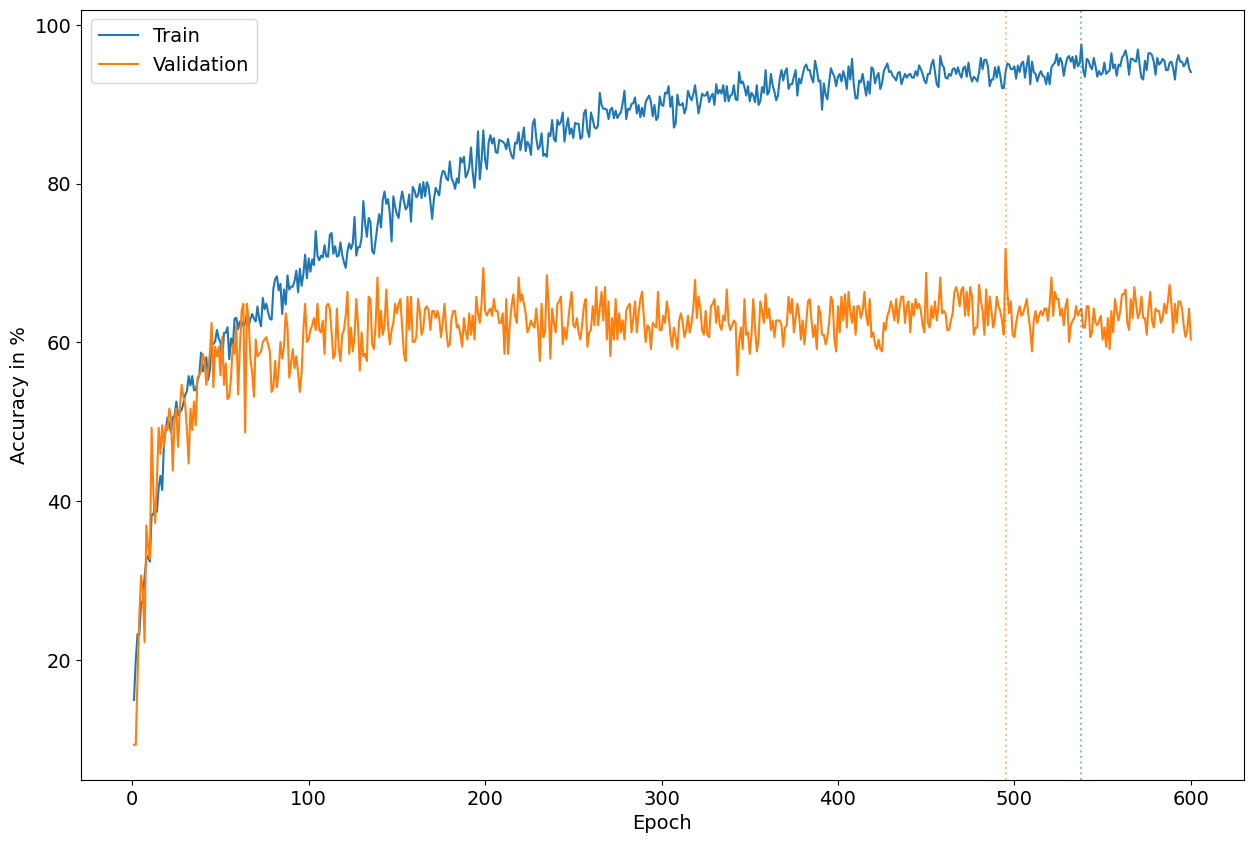

In [46]:
if TRAIN_MODEL:
    display_train_and_valid_values()

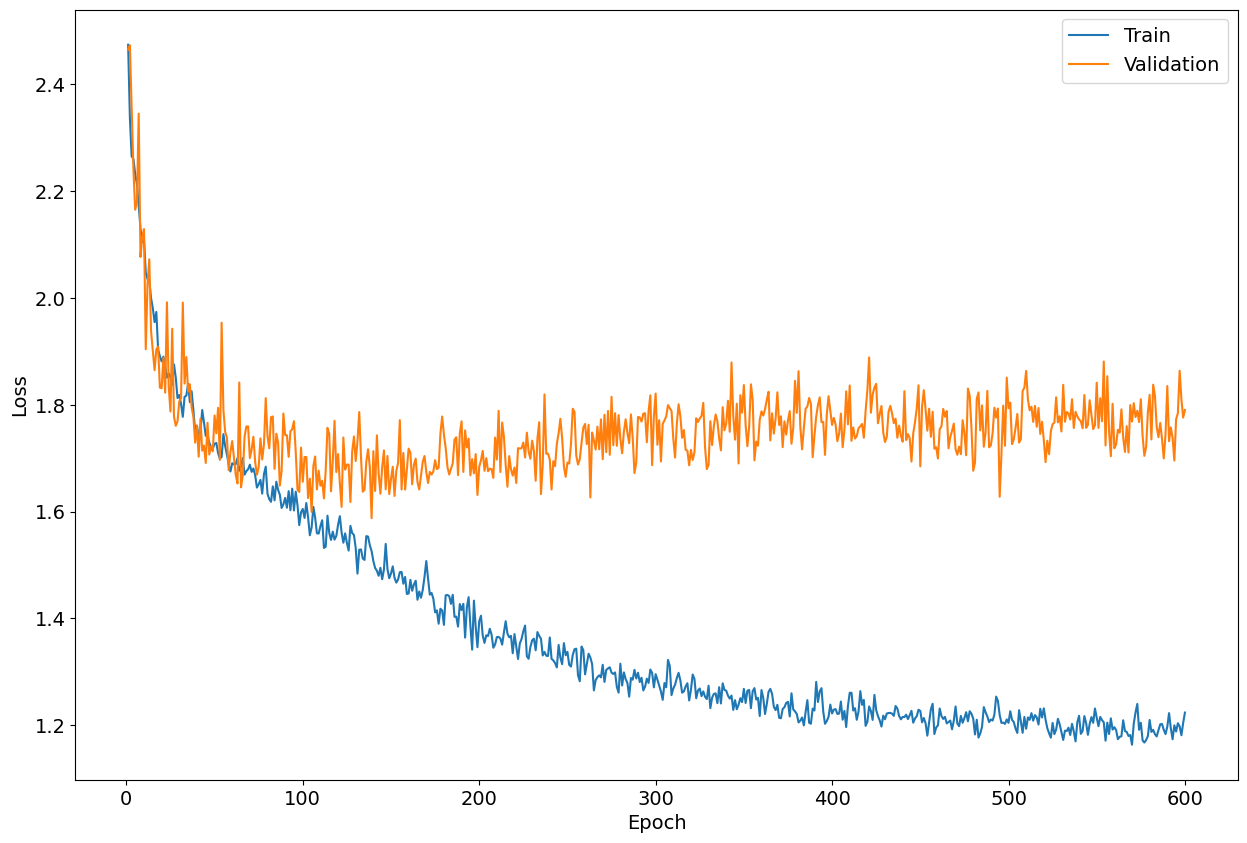

In [47]:
if TRAIN_MODEL:
    display_train_and_valid_values(information_to_display='loss')

### Testing trained model

In [ ]:
if ANALYZE_MODEL:
    # model_to_be_tested = PointNeXt(
    #     point_cloud_channel_depth = DATASET_CHANNEL_DEPTH,
    #     classes_count = NUM_CLASSES,
    #     stem_out_channel = PNTNXT_B_CONFIG.C,
    #     invresmlp_block_count = PNTNXT_B_CONFIG.B,
    #     # architecture_type = 1,    # this will make it a (semantic) segmentation model
    # ).to(DEVICE)

    
    model_to_be_tested = copy.copy(pointnext)
    
    file_to_be_loaded = f'{NN_MODEL_FOLDER}{os.sep}{TRAIN_MODEL_NAME}__version_{find_next_number(get_version_of_latest_saved_model=True)}.bin'

    # load parameters of model
    model_to_be_tested.load_state_dict(
        torch.load(
            file_to_be_loaded, 
            map_location=DEVICE
        )['state_dict']
    )
    
    print(f'file "{file_to_be_loaded}" was succesfully loaded')

In [46]:
test_dataset = PointCloudDataset(dataset_type='test')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)    # 509 is size of the whole test dataset

In [47]:
def test_model(passed_model, test_loader, loss_fn):
    passed_model.eval()

    losses = []
    predictions = []
    targets = []

    with torch.no_grad():
        for original, _, labels in test_loader:
            data, target = original.permute(0, 2, 1).to(DEVICE), labels.to(DEVICE)
            
            # Perform the forward pass
            output = passed_model(data)

            # Compute the loss
            loss = loss_fn(output, target)

            # Log the loss
            losses.append(loss.item())

            # Compute the prediction
            current_prediction = output.argmax(dim=1, keepdim=True)
            predictions.extend(current_prediction.cpu().numpy())
            targets.extend(target.argmax(dim=1, keepdim=True).cpu().numpy())

    return targets, predictions

In [48]:
if ANALYZE_MODEL:
    targets, predictions = test_model(model_to_be_tested, test_loader, PNTNXT_LOSS_FUNCTION)
    torch.cuda.empty_cache()  # clear the cache

#### Confussion matrix

In [49]:
def plot_confusion_matrix(
        targets, 
        predictions, 
        dataset=test_dataset,
        show_accuracy = False, 
        language=UI_LANGUAGE, 
        species_language=SPECIES_LANGUAGE
    ):
    dic_information = dataset.get_information_about_dataset()
    df = pd.read_csv(SPECIES_DATA_CSV_FILENAME, delimiter='\t', encoding='utf-8')

    substring = '_name'
    matching_columns = [col for col in df.columns if substring in col]
    language_columns = [col.replace(substring, '') for col in matching_columns]
    
    if species_language not in language_columns:
        raise ValueError('Language not supported')
    
    if  'latin' == species_language:
        species_names = list(dic_information.keys())
    else:
        species_names = [df.loc[df['latin_name'] == key, f'{species_language}_name'].values[0] for key in dic_information.keys()]


    # Compute the confusion matrix
    cm = confusion_matrix(targets, predictions)

    # Create a custom formatter function
    def fmt(x, pos):
        if language == 'slovenian':
            return '{:.2f}'.format(x).replace('.', ',').rstrip('0').rstrip(',')
        else:
            return '{:.2f}'.format(x).rstrip('0').rstrip('.')
    
    if show_accuracy:
        cm = confusion_matrix(targets, predictions)
        cm_normalized = normalize(cm, axis=1, norm='l1')
        accuracies = np.diag(cm_normalized) * 100

        # get longest name from species_names
        max_length = max(len(name) for name in species_names) + 2


        for i in range(len(accuracies)):
            num_spaces = max_length - len(species_names[i])
            empty_spaces = " " * num_spaces

            value = fmt(accuracies[i], None)
            num_spaces_after_value = 6 - len(str(value))
            empty_spaces_after_value = " " * num_spaces_after_value

            print(f'{species_names[i]}:{empty_spaces}{value}{empty_spaces_after_value}%')

        return

    # Create a new matplotlib figure
    fig, ax = plt.subplots(figsize=(15, 15))

    # Create a heatmap
    sns.heatmap(cm, annot=True, fmt=".2f", linewidths=1, square = True, cmap = 'Blues', ax=ax, xticklabels=species_names, yticklabels=species_names)

    # Format the annotations
    for text in ax.texts:
        text.set_text(fmt(float(text.get_text()), None))
        text.set_fontsize(14)  # You can adjust the font size as needed

    # Format the colorbar
    cbar = ax.collections[0].colorbar
    cbar.formatter = FuncFormatter(fmt)
    cbar.update_ticks()

    
    if language == 'slovenian':
        # Add labels to the x-axis and the y-axis
        ax.set_xlabel('Napovedana vrsta')
        ax.set_ylabel('Prava vrsta')

        # Add a title to the plot
        # ax.set_title('Normalizirana matrika zamenjav')
    else:
        # Add labels to the x-axis and the y-axis
        ax.set_xlabel('Predicted specie')
        ax.set_ylabel('True specie')

        # Add a title to the plot
        # ax.set_title('Normalized Confusion Matrix')


    # https://stackoverflow.com/a/39566040
    plt.rc('font', size=14)         # controls default text sizes

    # Display the plot
    plt.show()

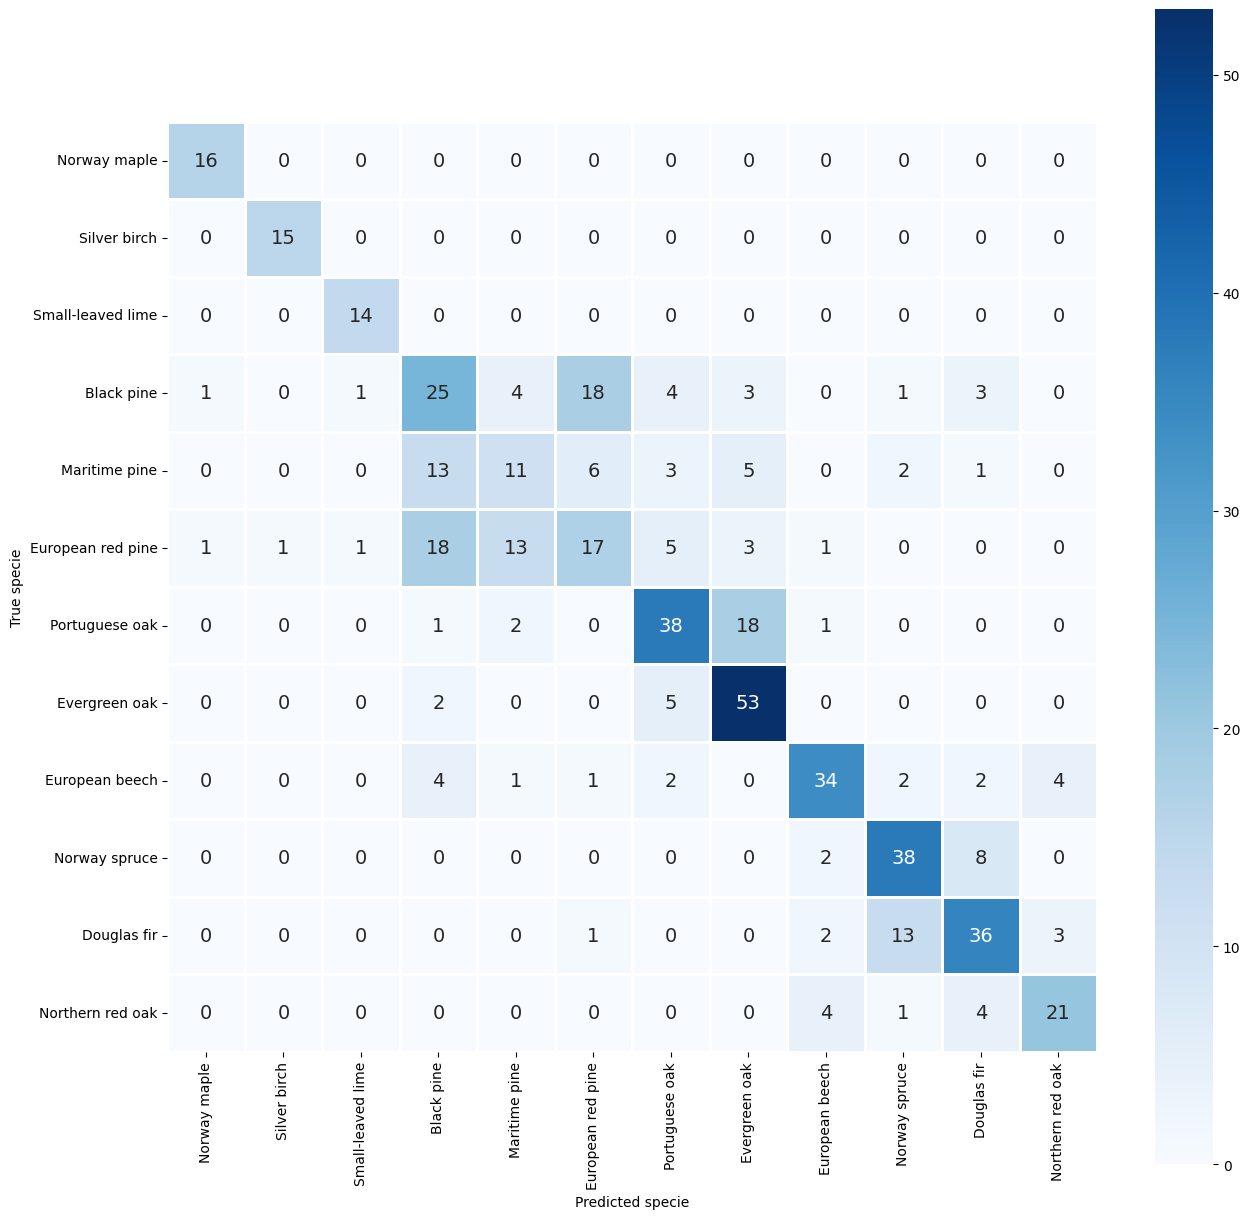

In [50]:
if ANALYZE_MODEL:
    plot_confusion_matrix(targets, predictions)

In [51]:
if ANALYZE_MODEL:
    plot_confusion_matrix(targets, predictions, show_accuracy=True)

Norway maple:       100   %
Silver birch:       100   %
Small-leaved lime:  100   %
Black pine:         41.67 %
Maritime pine:      26.83 %
European red pine:  28.33 %
Portuguese oak:     63.33 %
Evergreen oak:      88.33 %
European beech:     68    %
Norway spruce:      79.17 %
Douglas fir:        65.45 %
Northern red oak:   70    %


#### Other metrics

In [52]:
def show_classification_metrics(
        targets, 
        predictions, 
        dataset=test_dataset, 
        digits=2, 
        language=UI_LANGUAGE
    ):
    # tree_species = list(dataset.label_dic.keys())

    dic_information = dataset.get_information_about_dataset()
    df = pd.read_csv(SPECIES_DATA_CSV_FILENAME, delimiter='\t', encoding='utf-8')

    substring = '_name'
    matching_columns = [col for col in df.columns if substring in col]
    language_columns = [col.replace(substring, '') for col in matching_columns]
    
    if language not in language_columns:
        raise ValueError('Language not supported')
    
    if  'latin' == language:
        species_names = list(dic_information.keys())
    else:
        species_names = [df.loc[df['latin_name'] == key, f'{language}_name'].values[0] for key in dic_information.keys()]

    list_predictions = [item for sublist in predictions for item in sublist]
    list_targets = [item for sublist in targets for item in sublist]

    report = classification_report(list_targets, list_predictions, target_names=species_names, output_dict=True, zero_division=0)


    # Define the translations
    translations = {
        'english': {
            'precision': 'precision',
            'recall': 'recall',
            'f1-score': 'f1-score',
            'support': 'species count',
            'accuracy': 'overall accuracy',
            'macro avg': 'macro avg',
            'weighted avg': 'weighted avg'
        },
        'slovenian': {
            'precision': 'natančnost',
            'recall': 'priklic',
            'f1-score': 'mera f1',
            'support': 'število dreves',
            'accuracy': 'skupna točnost',
            'macro avg': 'makro povprečje',
            'weighted avg': 'uteženo povprečje'
        },
    }

    # Get the translations for the chosen language
    lang_translations = translations[language]

    # Calculate the maximum length of the strings in each column
    max_label_length = max([len(label) for label in species_names] + [len(lang_translations[avg]) for avg in ['accuracy', 'macro avg', 'weighted avg']])

    # Calculate the maximum length of the headers
    max_header_length = max([len(lang_translations[header]) for header in ['precision', 'recall', 'f1-score', 'support']])

    # Print the headers
    print(f"{'':<{max_label_length}} {lang_translations['precision'].rjust(max_header_length)} {lang_translations['recall'].rjust(max_header_length)} {lang_translations['f1-score'].rjust(max_header_length)} {lang_translations['support'].rjust(max_header_length)}\n")

    current_sample_count = 0
    # f1_scores = []
    # accuracies = []

    # Print the values for each label
    for label in species_names:
        precision = format(report[label]['precision'], f'.{digits}f')
        recall = format(report[label]['recall'], f'.{digits}f')
        f1_score = format(report[label]['f1-score'], f'.{digits}f')

        if language == 'slovenian':
            precision = precision.replace('.', ',')
            recall = recall.replace('.', ',')
            f1_score = f1_score.replace('.', ',')

        print(f"{label.rjust(max_label_length)} {precision.rjust(max_header_length)} {recall.rjust(max_header_length)} {f1_score.rjust(max_header_length)} {str(int(report[label]['support'])).rjust(max_header_length)}")

        current_sample_count += report[label]['support']
        # f1_scores.append(report[label]['f1-score'])
        # accuracies.append(report[label]['precision'])
   

    print()


    print(f"{lang_translations['accuracy'].rjust(max_label_length)} {' '.rjust(max_header_length)} {' '.rjust(max_header_length)} {format(report['accuracy'], f'.{digits}f').rjust(max_header_length)} {str(int(current_sample_count)).rjust(max_header_length)}")    # report['accuracy']


    # Print the averages
    for avg in ['macro avg', 'weighted avg']:
        precision = format(report[avg]['precision'], f'.{digits}f')
        recall = format(report[avg]['recall'], f'.{digits}f')
        f1_score = format(report[avg]['f1-score'], f'.{digits}f')

        if language == 'slovenian':
            precision = precision.replace('.', ',')
            recall = recall.replace('.', ',')
            f1_score = f1_score.replace('.', ',')
        
        print(f"{lang_translations[avg].rjust(max_label_length)} {precision.rjust(max_header_length)} {recall.rjust(max_header_length)} {f1_score.rjust(max_header_length)} {str(int(report[avg]['support'])).rjust(max_header_length)}")

In [53]:
if ANALYZE_MODEL:
    show_classification_metrics(targets, predictions)

                      precision        recall      f1-score species count

     Norway maple          0.89          1.00          0.94            16
     Silver birch          0.94          1.00          0.97            15
Small-leaved lime          0.88          1.00          0.93            14
       Black pine          0.40          0.42          0.41            60
    Maritime pine          0.35          0.27          0.31            41
European red pine          0.40          0.28          0.33            60
   Portuguese oak          0.67          0.63          0.65            60
    Evergreen oak          0.65          0.88          0.75            60
   European beech          0.77          0.68          0.72            50
    Norway spruce          0.67          0.79          0.72            48
      Douglas fir          0.67          0.65          0.66            55
 Northern red oak          0.75          0.70          0.72            30

 overall accuracy                   